In [1]:
import pandas as pd
from src.helper_functions.filterTranscripts import filterCanonicalTranscripts

gene = "BRCA2"

# transcripts = pd.read_csv(f"./data/VEP_annotations/{gene}.tsv", sep="\t")
transcripts = pd.read_csv("BRCA2_filtered_transcript_annotations.tsv", sep="\t")
# transcripts = filterCanonicalTranscripts(transcripts)
transcripts

,Unnamed: 0,biotype_functional_check,#Uploaded_variation,Location,Allele,Consequence,IMPACT,SYMBOL,Gene,Feature_type,...,AF,CLIN_SIG,SOMATIC,PHENO,PUBMED,MOTIF_NAME,MOTIF_POS,HIGH_INF_POS,MOTIF_SCORE_CHANGE,TRANSCRIPTION_FACTORS
0,1,1,.,13:32315507-32315507,C,upstream_gene_variant,MODIFIER,BRCA2,ENSG00000139618,Transcript,...,-,-,-,-,-,-,-,-,-,-
1,5,1,.,13:32315507-32315507,C,upstream_gene_variant,MODIFIER,ZAR1L,ENSG00000189167,Transcript,...,-,-,-,-,-,-,-,-,-,-
2,22,1,.,13:32315507-32315507,G,upstream_gene_variant,MODIFIER,BRCA2,ENSG00000139618,Transcript,...,-,-,-,-,-,-,-,-,-,-
3,26,1,.,13:32315507-32315507,G,upstream_gene_variant,MODIFIER,ZAR1L,ENSG00000189167,Transcript,...,-,-,-,-,-,-,-,-,-,-
4,43,1,.,13:32315507-32315507,T,upstream_gene_variant,MODIFIER,BRCA2,ENSG00000139618,Transcript,...,-,-,-,-,-,-,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44164,608668,1,.,13:32400267-32400267,C,3_prime_UTR_variant,MODIFIER,BRCA2,ENSG00000139618,Transcript,...,-,-,-,-,-,-,-,-,-,-
44165,608690,1,.,13:32400267-32400267,G,downstream_gene_variant,MODIFIER,N4BP2L1,ENSG00000139597,Transcript,...,-,-,-,-,-,-,-,-,-,-
44166,608693,1,.,13:32400267-32400267,G,3_prime_UTR_variant,MODIFIER,BRCA2,ENSG00000139618,Transcript,...,-,-,-,-,-,-,-,-,-,-
44167,608715,1,.,13:32400267-32400267,T,downstream_gene_variant,MODIFIER,N4BP2L1,ENSG00000139597,Transcript,...,-,-,-,-,-,-,-,-,-,-


In [2]:
from Bio import SeqIO

def load_fasta(fasta_file):
    # Load the entire FASTA file into a dictionary for quick access
    fasta_dict = {}
    for record in SeqIO.parse(fasta_file, "fasta"):
        fasta_dict[record.id] = record.seq
    return fasta_dict

def extract_trimer(seq_dict, location):
    # Parse the location string
    chromosome, pos_range = location.split(':')
    start_pos, end_pos = map(int, pos_range.split('-'))

    if start_pos != end_pos:
        raise ValueError(f"Start and end positions should be the same for location: {location}")

    # Identify the relevant sequence in the dictionary
    for key in seq_dict:
        chrom_key, range_key = key.split(':')
        start_range, end_range = map(int, range_key.split('-'))
        
        # Check if the location falls within the sequence range
        if chrom_key == 'chr' + chromosome and start_range <= start_pos <= end_range:
            # Calculate the index relative to the sequence
            relative_pos = start_pos - start_range
            
            # Extract the trimer centered at the given location
            trimer_start = relative_pos - 1
            trimer_end = relative_pos + 1
            trimer = seq_dict[key][trimer_start:trimer_end+1]
            return str(trimer)
    
    # If no matching sequence is found
    raise ValueError(f"Location {location} not found in the provided sequences.")
    
def get_reverse_complement(seq: str):
    comp_hash = {
        "A": "T",
        "C": "G",
        "G": "C",
        "T": "A"
    }

    new_seq = ""
    for n in seq[::-1]:
        new_seq += comp_hash[n]

    return new_seq

In [3]:
from src.helper_functions.filterTranscripts import getRank, getRankHash

fasta_dict = load_fasta(f"./data/extracts/2024-08-14-10:17:20.410123_extract/geneFASTAs/{gene}.fa")

trinlist = ['ACA', 'ACC', 'ACG', 'ACT', 'CCA', 'CCC', 'CCG', 'CCT', 'GCA', 'GCC', 'GCG', 'GCT', 'TCA', 'TCC', 'TCG', 'TCT', 'ATA', 'ATC', 'ATG', 'ATT', 'CTA', 'CTC', 'CTG', 'CTT', 'GTA', 'GTC', 'GTG', 'GTT', 'TTA', 'TTC', 'TTG', 'TTT']
trimers = list(map(lambda x: extract_trimer(fasta_dict, x), list(transcripts["Location"])))
transcripts.insert(0, "Trimer", trimers)

rank_hash = getRankHash("./data/classification_data/consequence_terms.txt")
cweight_counts = {consequence: [0 for _ in trinlist] for consequence in rank_hash}

for consequence in cweight_counts:
    for i in range(len(trinlist)):
        trimer = trinlist[i]
        filteredS1 = transcripts[transcripts["Trimer"] == trimer]
        filteredS2 = filteredS1[filteredS1["Consequence"] == consequence]

        adder = len(list(filteredS2["Trimer"]))
        cweight_counts[consequence][i] += adder

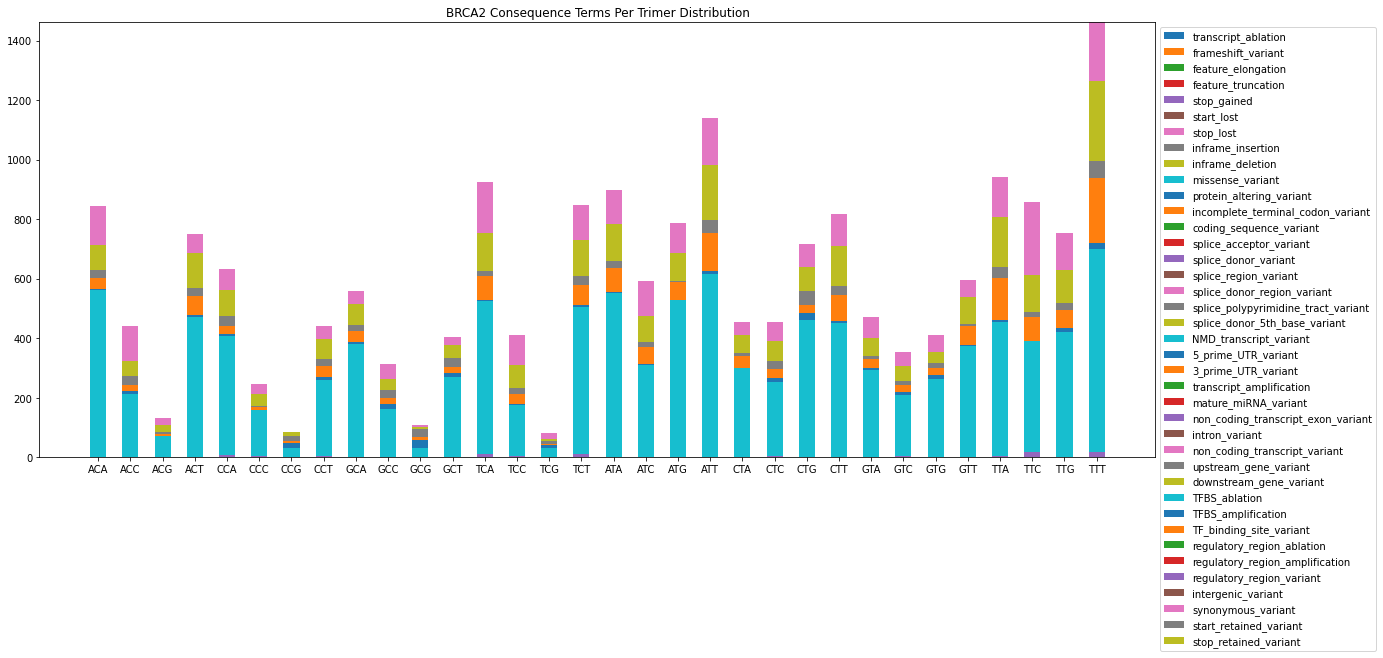

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# data from https://allisonhorst.github.io/palmerpenguins/

species = trinlist# [key for key in trimer_rank_count]
# weight_counts = get_weight_counts()
# weight_counts = generate_weight_counts(trimer_rank_count)

def generate_stacked_bar(species, weight_counts, title, filename):
    width = 0.5

    fig, ax = plt.subplots(figsize=(20, 8))
    bottom = np.zeros(32)

    for boolean, weight_count in weight_counts.items():
        p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
        bottom += weight_count

    ax.set_title(title)
    # ax.legend(loc="upper right")
    ax.legend(loc="upper left", bbox_to_anchor=(1, 1))


    plt.savefig(filename)
    plt.show()

generate_stacked_bar(species, cweight_counts, "BRCA2 Consequence Terms Per Trimer Distribution", "BRCA2_ALLConsequences_Trimer_Plot.png")

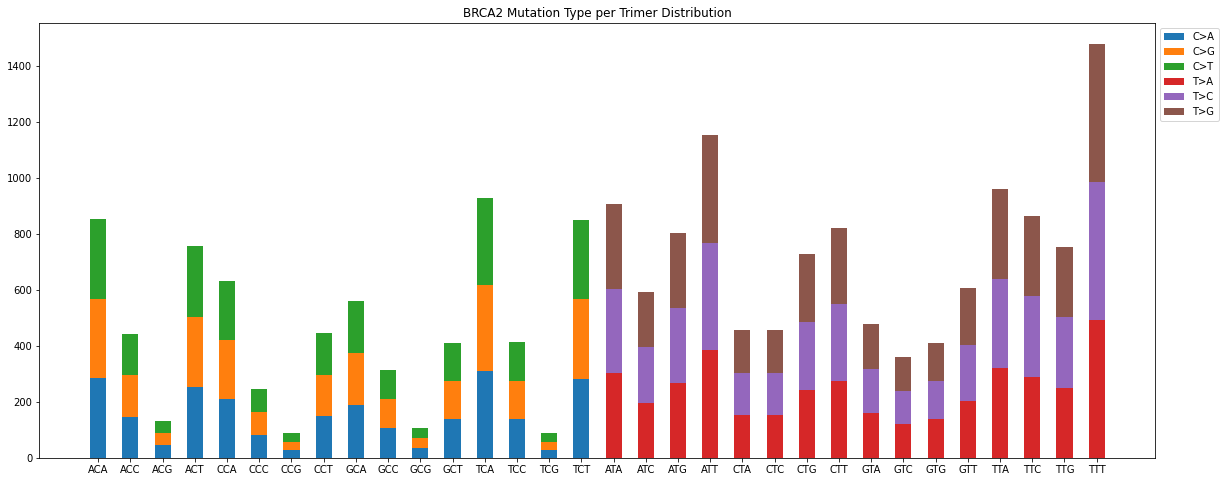

In [5]:
complement_hash = {"G": "C", "A": "T", "C": "G", "T": "A"}

def get_alt_allele(uploaded_allele_string):
    return uploaded_allele_string.split("/")[-1]

def get_mutation_type(ref, alt):
    if (ref != "C") and (ref != "T"):
        # print(ref, alt)
        ref = complement_hash[ref]
        alt = complement_hash[alt]
    
    return f"{ref}>{alt}"
        

mutation_type_list = ["C>A", "C>G", "C>T", "T>A", "T>C", "T>G"]

alt_alleles = list(map(get_alt_allele, transcripts["UPLOADED_ALLELE"]))
transcripts.insert(0, "ALT", alt_alleles)

mutation_types = list(map(lambda x: get_mutation_type(x[0], x[1]), zip(list(transcripts["REF_ALLELE"]), list(transcripts["ALT"]))))
transcripts.insert(0, "mutation_type", mutation_types)

# print(mweight_counts)

mweight_counts = {mutation_type: [0 for _ in trinlist] for mutation_type in mutation_type_list}
for mutation_type in mweight_counts:
    for i in range(len(trinlist)):
        trimer = trinlist[i]
        filteredS1 = transcripts[transcripts["Trimer"] == trimer]
        filteredS2 = filteredS1[filteredS1["mutation_type"] == mutation_type]

        adder = len(list(filteredS2["Trimer"]))
        mweight_counts[mutation_type][i] += adder
        

generate_stacked_bar(species, mweight_counts, "BRCA2 Mutation Type per Trimer Distribution", "BRCA2_mutation_type_plot.png")

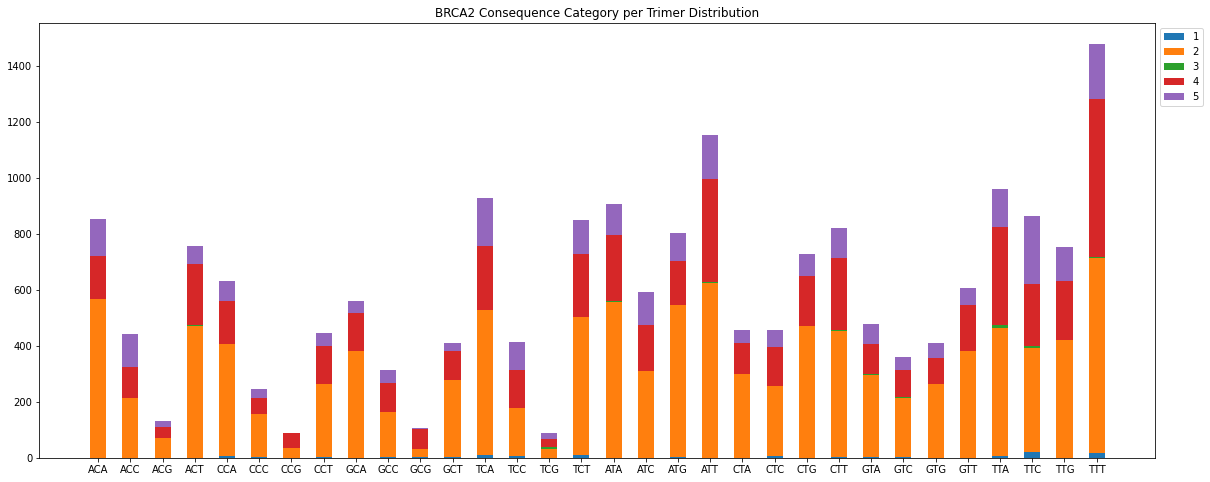

In [6]:
rank_hash = getRankHash("./data/classification_data/consequence_terms.txt")

consequences = list(transcripts["Consequence"])
consequence_ranks = list(map(lambda x: getRank(x, rank_hash), consequences))

transcripts.insert(0, "consequence_rank", consequence_ranks)

ranks = [1, 2, 3, 4, 5]
rweight_counts = {rank: [0 for _ in trinlist] for rank in ranks}
for rank in rweight_counts:
    for i in range(len(trinlist)):
        trimer = trinlist[i]
        filteredS1 = transcripts[transcripts["Trimer"] == trimer]
        filteredS2 = filteredS1[filteredS1["consequence_rank"] == rank]
        

        adder = len(list(filteredS2["Trimer"]))
        rweight_counts[rank][i] += adder

generate_stacked_bar(trinlist, rweight_counts, "BRCA2 Consequence Category per Trimer Distribution", "BRCA2_consequence_category_plot.png")

GENERATION OF 32-vec DESCRIPTOR | EXTRACTED SEQUENCES


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 12.11it/s]


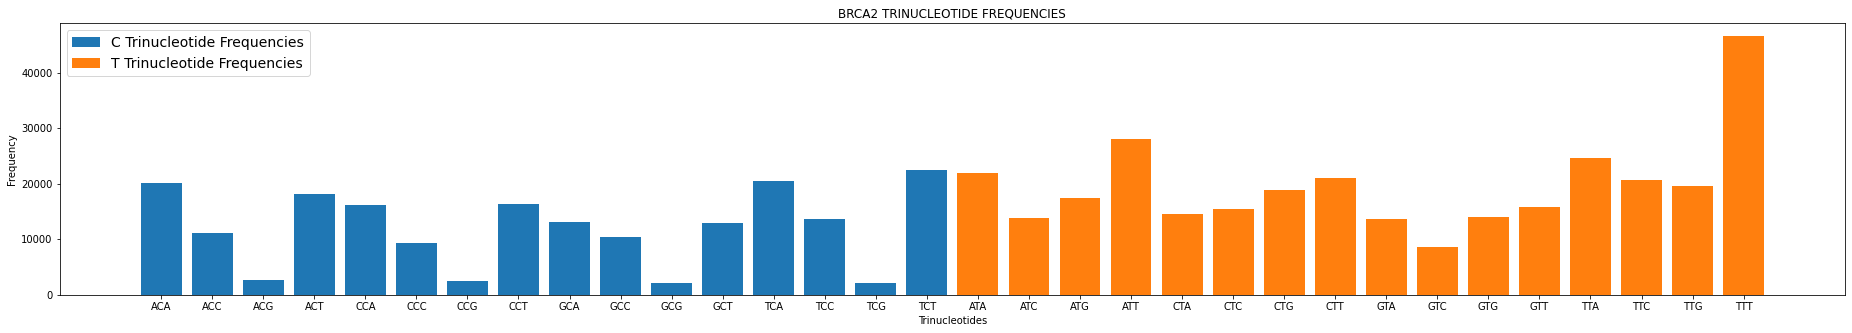

In [25]:
import numpy as np
from src.CalcMRate.CalcMRate2 import CalcMRate

c = CalcMRate("./data/bed_data/BRCA2_hg38.bed", "./data/fasta_data/hg38.fa", "./data/extraction_dir", "extracted_test", np.random.rand(96))
out = c.get_spec32()
trinlist, BRCA2_trimer_freq_vec = out

import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(32,5)) # set the size that you'd like (width, height)
plt.bar(trinlist[:16], BRCA2_trimer_freq_vec[:16])
plt.bar(trinlist[16:], BRCA2_trimer_freq_vec[16:])
plt.title('BRCA2 TRINUCLEOTIDE FREQUENCIES')
plt.xlabel('Trinucleotides')
plt.ylabel('Frequency')
ax.legend(["C Trinucleotide Frequencies", "T Trinucleotide Frequencies"], fontsize = 14)

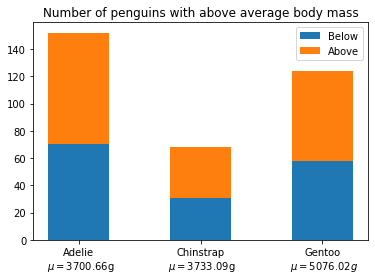

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# data from https://allisonhorst.github.io/palmerpenguins/

species = (
    "Adelie\n $\\mu=$3700.66g",
    "Chinstrap\n $\\mu=$3733.09g",
    "Gentoo\n $\\mu=5076.02g$",
)
weight_counts = {
    "Below": np.array([70, 31, 58]),
    "Above": np.array([82, 37, 66]),
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(3)

for boolean, weight_count in weight_counts.items():
    p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_title("Number of penguins with above average body mass")
ax.legend(loc="upper right")

plt.show()

In [18]:
transcripts.to_csv("transcripts_ex.tsv", sep="\t")